# 3D VGGNet for binary classification

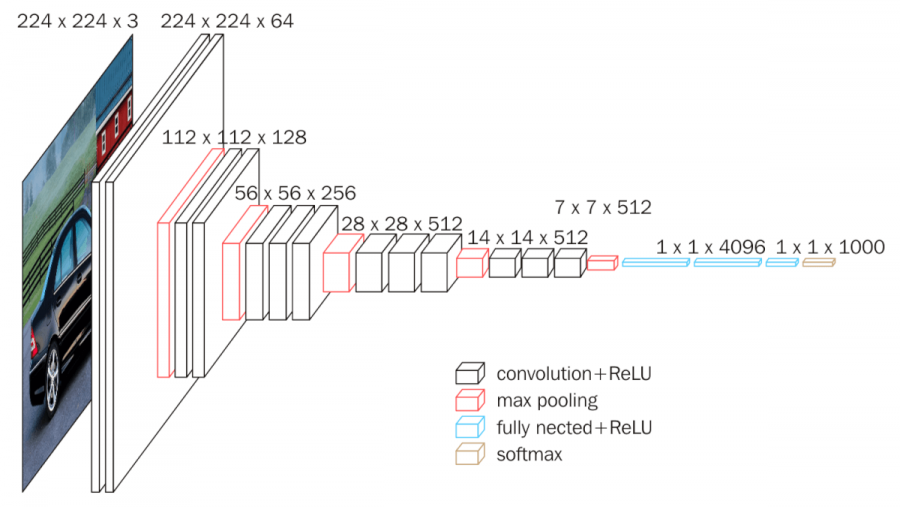

In [ ]:
import torch
import torch.nn as nn

In [ ]:
VGG_types = {
    'VGG11' : [64, 'M', 128, 'M', 256, 256, 'M', 512,512, 'M',512,512,'M'],
    'VGG13' : [64,64, 'M', 128, 128, 'M', 256, 256, 'M', 512,512, 'M', 512,512,'M'],
    'VGG16' : [64,64, 'M', 128, 128, 'M', 256, 256,256, 'M', 512,512,512, 'M',512,512,512,'M'],
    'VGG19' : [64,64, 'M', 128, 128, 'M', 256, 256,256,256, 'M', 512,512,512,512, 'M',512,512,512,512,'M']
}
class VGGnet(nn.Module):
    def __init__(self, model, in_channels=3, num_classes=10, init_weights=True):
        super(VGGnet,self).__init__()
        self.in_channels = in_channels

        # create conv_layers corresponding to VGG type
        self.conv_layers = self.create_conv_laters(VGG_types[model])

        self.fcs = nn.Sequential(
            nn.Linear(1536, 1536//2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1536//2, 1536//2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1536//2, num_classes),
        )

        # weight initialization
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fcs(x)
        return x

    # defint weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    # define a function to create conv layer taken the key of VGG_type dict 
    def create_conv_laters(self, architecture):
        layers = []
        in_channels = self.in_channels # 3

        for x in architecture:
            if type(x) == int: # int means conv layer
                out_channels = x

                layers += [nn.Conv3d(in_channels=in_channels, out_channels=out_channels,
                                     kernel_size=(3,2,3), stride=(1,1,1), padding=(1,1,1)),
                           nn.BatchNorm3d(x),
                           nn.ReLU()]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool3d(kernel_size=(2,2,2), stride=(2,2,2))]
        
        return nn.Sequential(*layers)

In [ ]:
# define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creat VGGnet object
# Choose between 'VGG11', 'VGG13', 'VGG16', 'VGG19'
model = VGGnet('VGG16', in_channels=1, num_classes=1, init_weights=True).to(device)
print(model)

In [ ]:
ex = torch.rand(3,1,32,32,32).to(device)
out = model(ex)
print(out.size())